**Project:** Disease Diagnosis

**Problem:** Image Multi-Classification / Image Recogntiion

## 1- Imports

In [28]:
import os
from os import walk
import copy
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import ImageFile

## 2- Load Data

We load image data with ImageFolder, which allows us to load image data and transform it to appropriate format, while also defining the labels of the data through the directory structure in "../Data/raw_data/train"

In [16]:
image_paths = {}

for (dirpath, dirnames, filenames) in walk("../Data/raw_data/"):
#     dirpath = dirpath.replace('\\', '/')
    # print("Directory path: ", dirpath)
    # print("Folder name: ", dirnames)
    if len(dirnames) == 0:
        image_paths[dirpath.split('/')[-1].replace('\\', '/')] = dirpath.replace('\\', '/')

print(f"Test Directory: {image_paths['test']}")
print(f"Train Directories:" , end=' ')
for i in list(image_paths.keys())[1:]:
    print(f"{i}", end=', ')

Test Directory: ../Data/raw_data/test
Train Directories: temp/normal, temp/virus, test, train/covid, train/normal, train/virus, 

In [24]:
# helper functions
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs + torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy, 0., 1.)
     return noisy
    

In [23]:
# # tensor conversion + normalization(range:[-1,1])
dataset_list = []

# transform = transforms.Compose( 
#     [transforms.Resize((640, 480)),
#      transforms.ToTensor(), 
#      transforms.Grayscale()])
imageW = 320
imageH = 240

# transform2 = transforms.Compose( 
#     [transforms.RandomRotation(degrees=30),
#      transforms.Resize((imageW, imageH)),
#      transforms.ToTensor()]
# )

# transform3 = transforms.Compose( 
#     [transforms.RandomRotation(degrees=15),
#      transforms.Resize((imageW, imageH)),
#      transforms.Grayscale(),
#      transforms.ToTensor()]
# )

# transform4 =  transforms.Compose( 
#     [transforms.GaussianBlur(kernel_size=(51, 91), sigma=2),
#      transforms.Resize((imageW, imageH)),
#      transforms.ToTensor()]
# )

transform5 = transforms.Compose( 
    [transforms.Resize((640, 480)),
     transforms.ToTensor()]
)

transform6 = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
      transforms.RandomHorizontalFlip(p=0.5), 
      transforms.RandomVerticalFlip(p=0.5),  
     transforms.ToTensor()]
)

# transform7 = transforms.Compose( 
#     [transforms.Resize((640, 480)),
#      transforms.RandomVerticalFlip(p=0.5),  
#      transforms.ToTensor()]
# )


# dataset = datasets.ImageFolder('../Data/raw_data/train/', transform=transform)
# dataset_list.append(dataset)
# dataset2 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform2)
# dataset_list.append(dataset2)
# dataset3 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform3)
# dataset_list.append(dataset3)
# dataset4 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform4)
# dataset_list.append(dataset4)
dataset5 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform5)
dataset_list.append(dataset5)
dataset6 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform6)
dataset_list.append(dataset6)
# dataset7 = datasets.ImageFolder('../Data/raw_data/train/', transform=transform7)
# dataset_list.append(dataset7)

print(f"Number of Datasets Made: {len(dataset_list)}")

Number of Datasets Made: 2


In [26]:
# saving augmented data
for i, data_set in enumerate(dataset_list):
    class_mappings = data_set.classes
    print(f'dataset {i+1}')
    print('classes: ', class_mappings)
    for img_index, data in enumerate(data_set):
        tens, label = data
        sub_dir = class_mappings[label]
        if i == 0:
            tens = add_noise(tens, noise_factor=0.2) 
        save_image(tens, f'../Data/data_augmented/train/{sub_dir}/img_{i+1}_{img_index+1}_aug3.png')
    print('-' * 30)

dataset 1
classes:  ['covid', 'normal', 'virus']
------------------------------
dataset 2
classes:  ['covid', 'normal', 'virus']
------------------------------


In [5]:
# class_mappings = dataset.class_to_idx
# for i, dataset in enumerate([dataset2, dataset3, dataset4]):
#     print(f'dataset {i+2}')
#     for path, class_num in dataset.imgs:
#         name = path.split('\\')[-1]
#         new_name = str(i+2) + '_' + name
#         new_path = ''.join(path.split('\\')[:-1]) + '/' + new_name
#         print(path)
#         print(new_path)
        
#     print('-' * 100)

In [52]:
simple_transform = transforms.Compose( 
    [transforms.Resize((imageW, imageH)),
     transforms.ToTensor()]) # mean = 0.5, std = 0.5

# Load Data + Transform
main_dataset = datasets.ImageFolder('../Data/data_augmented/train/', transform=simple_transform)
val_dataset = datasets.ImageFolder('../Data/raw_data/train/', transform=simple_transform)

test_frac = 0.2

shuffle_dataset = True
dataset_size = len(val_dataset)
indices = list(range(dataset_size))
test_split_1 = int(np.floor(test_frac * dataset_size))
random_seed= 42
batch_size = 32
num_workers = 2
classes = ('covid', 'normal', 'virus')

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
test_indices, val_indices = indices[: test_split_1], indices[test_split_1: ] 

# Creating PT data samplers and loaders:
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define Data Loader Object
dataloader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(main_dataset, batch_size=batch_size, sampler=test_sampler)

**NOTE** We use num_workers because it allows us to speed up the training process by utilizing machines with multiple cores.


**NOTE** DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

## 3- Show Images

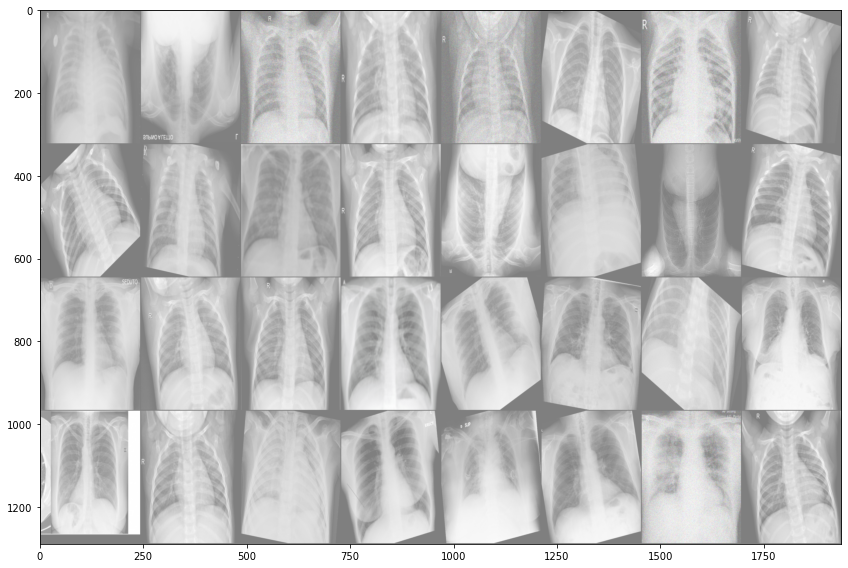

Image Types: ('covid', 'normal', 'virus')


In [56]:
def imshow(img):
    ''' function to show image '''
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    fig, ax = plt.subplots(figsize=(18, 8))
    # ax.imshow(random.rand(8, 90), interpolation='nearest')
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

# get random training images with iter function
dataiter = iter(dataloader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# # print the class of the image
print(f"Image Types: {classes}")
# count = range(1, batch_size+1)
# print(f'image {count}: ', end='')
# print(f'\nimage {next(count)}: '.join('%s' % classes[labels[j]] for j in range(batch_size)))

## 4- Model Definition

### 4.1 Model 1

In [47]:
# Defining CNN Model
class Net(nn.Module):
    def __init__(self):
        '''initialize the network'''
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 157 *117, 120) # 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, np.prod(x.shape[1:]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [15]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.2 Model 2

In [60]:
# helper functions 
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [61]:
# defined Parameters (Net2)
Net2_params_model = {
    "shape_in": (3, imageW, imageH), 
    "initial_filters": 8,    
    "num_fc1": 400,
    "dropout_rate": 0.25,
    "num_classes": 3
}

In [82]:
class Net2(nn.Module):
    # Network Initialisation
    def __init__(self, params):
        super(Net2, self).__init__()
        
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv5)
        
        # compute the flatten size
        self.num_flatten=h*w*16*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)); X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X));X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X));X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv5(X));X = F.max_pool2d(X, 2, 2)
        

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    
net = Net2(Net2_params_model)
print(net)

Net2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5120, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
)


In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

In [84]:
# defining loss function and optimizer
# choice 1
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# choice 2
criterion = nn.NLLLoss(reduction="sum")
optimizer = optim.Adam(net.parameters(), lr=3e-4)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20, verbose=1)

**NOTE** (lr_scheduler) Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.

## 5- Model Training

### 5.1 Model 1

In [66]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
num_epochs = 50
ImageFile.LOAD_TRUNCATED_IMAGES = True

start.record()

for epoch in range(num_epochs):
    print(f'epoch: {epoch}')

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0): 
        # loop to enumerate over the batches from dataloader starting from index = 0
        
        inputs, labels = data

        # parameter initialization (gradients to zero) 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # mini-batch size is 2000
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

**NOTE** we can use **torch.cuda.Event** if we are using a GPU powered training since cuda operations are asynchronous

In [61]:
# # save
# PATH = '../Results/CNN_torch_model.pth'
# torch.save(net.state_dict(), PATH)

# # reload
# net = Net()
# net.load_state_dict(torch.load(PATH))

### 5.2 Model 2

In [85]:
## helper functions

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, check=False, opt=None):
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

        # break the loop in case of sanity check
        if check is True:
            break
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [86]:
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    check=params["check"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    # main loop
    for epoch in range(epochs):
        print('-' * 70)
        # print(f'epoch {epoch+1}')
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        ''' Train the Model on the Training Set '''
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,check,opt)

        ''' Collect loss and metric for training dataset ''' 
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        ''' Evaluate model on validation dataset '''
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model, loss_func, val_dl,check)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [87]:
# defined paramters for training
Model2_params_train = {
    "train": dataloader, "val": valloader,
    "epochs": 50,
    "optimiser": optimizer,
    "lr_change": lr_scheduler,
    "f_loss": criterion,
    "weight_path": "../Results/Model_Weights/2-moh-torch-model-4-weights.pt",
    "check": False, 
}

In [88]:
# train and validate the model
cnn_model, loss_hist, metric_hist = train_val(net, Model2_params_train, verbose=True)

----------------------------------------------------------------------
Epoch 0/49, current lr=0.0003
Copied best model weights!
train loss: 0.764828, dev loss: 0.298241, accuracy: 68.73
----------
----------------------------------------------------------------------
Epoch 1/49, current lr=0.0003
Copied best model weights!
train loss: 0.362139, dev loss: 0.208302, accuracy: 72.07
----------
----------------------------------------------------------------------
Epoch 2/49, current lr=0.0003
Copied best model weights!
train loss: 0.256843, dev loss: 0.181600, accuracy: 73.08
----------
----------------------------------------------------------------------
Epoch 3/49, current lr=0.0003
Copied best model weights!
train loss: 0.206156, dev loss: 0.125856, accuracy: 75.00
----------
----------------------------------------------------------------------
Epoch 4/49, current lr=0.0003
Copied best model weights!
train loss: 0.182182, dev loss: 0.090286, accuracy: 76.92
----------
---------------

train loss: 0.023631, dev loss: 0.012902, accuracy: 79.68
----------
----------------------------------------------------------------------
Epoch 46/49, current lr=0.0003
train loss: 0.007955, dev loss: 0.000465, accuracy: 80.02
----------
----------------------------------------------------------------------
Epoch 47/49, current lr=0.0003
train loss: 0.011711, dev loss: 0.001161, accuracy: 80.02
----------
----------------------------------------------------------------------
Epoch 48/49, current lr=0.0003
train loss: 0.008480, dev loss: 0.001915, accuracy: 80.02
----------
----------------------------------------------------------------------
Epoch 49/49, current lr=0.0003
train loss: 0.004316, dev loss: 0.000558, accuracy: 80.02
----------


## 6- Model Evaluation

In [90]:
# Train-Validation Progress
epochs=Model2_params_train["epochs"]

fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["train"],name='loss_hist["train"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=loss_hist["val"],name='loss_hist["val"]'),row=1, col=1)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["train"],name='metric_hist["train"]'),row=1, col=2)
fig.add_trace(go.Scatter(x=[*range(1,epochs+1)], y=metric_hist["val"],name='metric_hist["val"]'),row=1, col=2)
fig.update_layout(template='plotly_white');fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
fig.show()

### 6.1 Test on Sample data

In [141]:
dataiter = iter(testloader)

test 1


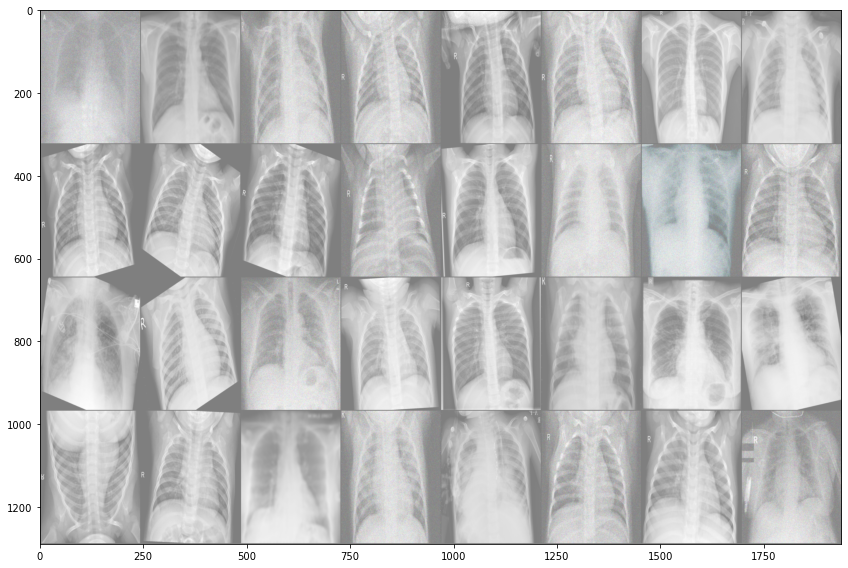

GroundTruth:  covid covid virus normal normal normal normal virus normal normal normal normal normal virus covid normal covid virus covid normal normal virus covid covid normal normal covid virus virus normal normal covid
Predicted:  covid covid virus normal normal normal normal virus normal normal normal normal normal virus covid normal covid virus covid normal normal virus covid covid normal normal covid virus virus normal normal covid
----------------------------------------------------------------------------------------------------

test 2


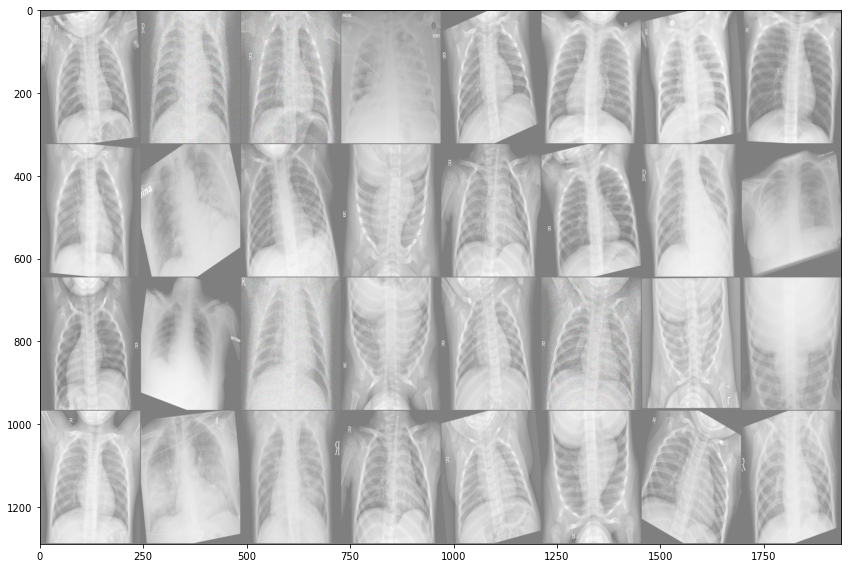

GroundTruth:  normal virus virus covid normal normal virus normal normal covid covid normal normal normal virus covid normal covid virus normal normal normal normal virus normal covid virus normal normal normal normal virus
Predicted:  normal virus virus covid normal normal virus normal normal covid covid normal normal normal virus covid normal covid virus normal normal normal normal virus normal covid virus normal normal normal normal virus
----------------------------------------------------------------------------------------------------

test 3


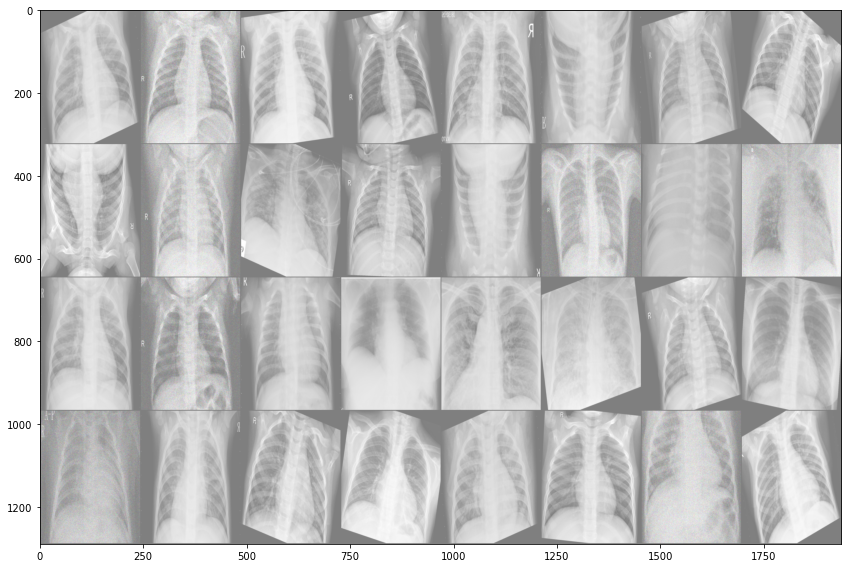

GroundTruth:  virus normal virus normal virus virus virus normal normal normal covid normal virus normal virus covid virus normal virus covid covid covid normal covid virus virus virus virus virus normal virus virus
Predicted:  virus normal virus normal virus virus virus normal normal normal covid normal virus normal virus covid virus normal virus covid covid covid normal covid virus virus virus virus virus normal virus virus
----------------------------------------------------------------------------------------------------

test 4


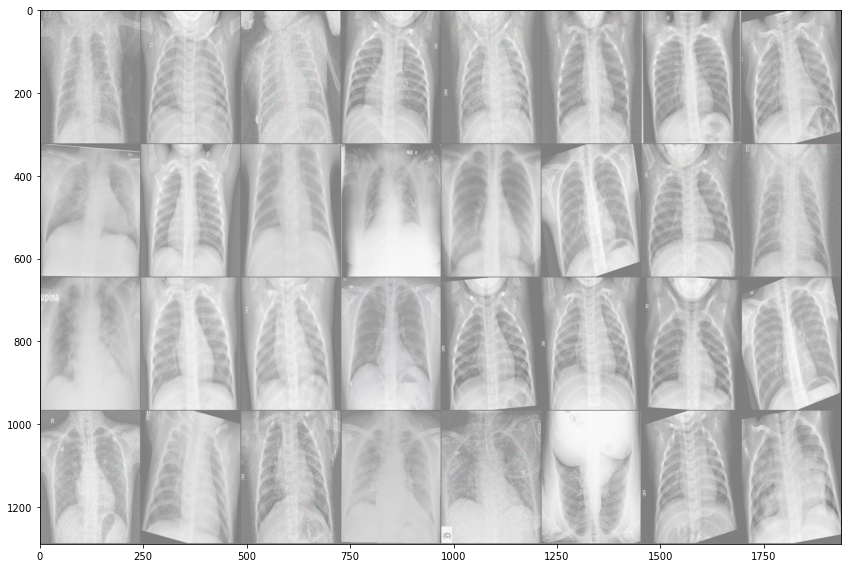

GroundTruth:  virus normal virus normal normal normal normal normal covid normal virus covid covid normal normal virus covid normal normal covid normal normal normal normal normal virus virus covid covid covid normal virus
Predicted:  virus normal virus normal normal normal normal normal covid normal virus covid covid normal normal virus covid normal normal covid normal normal normal normal normal virus virus covid covid covid normal virus
----------------------------------------------------------------------------------------------------

test 5


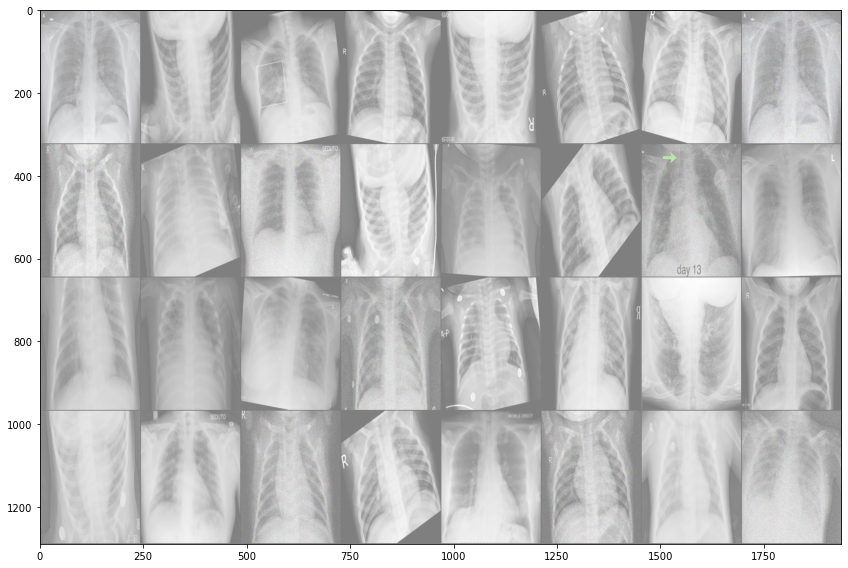

GroundTruth:  covid virus covid normal virus normal virus covid normal virus covid virus virus virus covid covid virus virus covid virus virus virus covid normal virus covid virus virus covid normal virus virus
Predicted:  covid virus covid normal virus normal virus covid normal virus covid virus virus virus covid covid virus virus covid virus virus virus covid normal virus covid virus virus covid normal virus virus
----------------------------------------------------------------------------------------------------



In [91]:
# print images
for test in range(5):
    print('test {}'.format(test+1))
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(len(images))))
    images = images.to(device)
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                                  for j in range(len(images))))
    print('-' * 100, end='\n\n')

### 6.2 Model Accuracy

In [92]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print('labels ', labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
print('Pytorch (Baseline): 90% accuracy')
print('Pytorch (100 epochs): 89% accuracy')
print('Pytorch (higher resolution): 91% accuracy')
print('Pytorch (higher batch size): 90% accuracy')
print('Pytorch (image augmentation (replace data)): 87-89% accuracy')
print('Pytorch (image augmentation (add to data, 5x data)): 94% accuracy')
print('Pytorch (image augmentation (add to data, 5x data), higher resolution): 93%-94% accuracy')
print('Pytorch (image augmentation (add to data, 5x data), higher resolution, bigger batch, smaller test split): 93% accuracy')

Pytorch (Baseline): 90% accuracy
Pytorch (100 epochs): 89% accuracy
Pytorch (higher resolution): 91% accuracy
Pytorch (higher batch size): 90% accuracy
Pytorch (image augmentation (replace data)): 87-89% accuracy
Pytorch (image augmentation (add to data, 5x data)): 94% accuracy
Pytorch (image augmentation (add to data, 5x data), higher resolution): 93%-94% accuracy
Pytorch (image augmentation (add to data, 5x data), higher resolution, bigger batch, smaller test split): 93%-94% accuracy


### 6.3 Inference on Submission Data

In [93]:
rootpath = '../Data/raw_data/test'
paths = []
for subdir, dirs, files in walk(rootpath):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        paths.append(filepath)

class TestDataset(Dataset):
    def __init__(self):
        images_processed = []
        self.imagelist = paths
        

    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, index):
        self.imagepath = self.imagelist[index]
        self.image = Image.open(self.imagepath)
        self.image = self.image.convert("RGB")
        
        transform = transforms.Compose( 
            [transforms.Resize((imageW, imageH)),
             transforms.ToTensor()])
        
        # Note: transform already defined above
        i = transform(self.image)
        images_processed.append(self.imagepath.replace('\\', '/'))
        return i


submission_dataset = TestDataset()
submloader = torch.utils.data.DataLoader(submission_dataset, batch_size=32)

In [94]:
num_images = 0
images_processed = []
all_predictions = []

for batch_num, images in enumerate(submloader):
    print(f'batch {batch_num + 1} ({len(images)} images)')
    images = images.to(device)
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)
    predictions = [classes[predicted[j]] for j in range(len(images))]
    all_predictions.extend(predictions)
    print('Predicted:', ' '.join(predictions))
    print()
print('-' * 50)
    
print(f'number of images processed: {len(images_processed)}')
print(f'number of images predicted: {len(all_predictions)}')

batch 1 (32 images)
Predicted: covid virus covid normal virus virus covid covid virus virus normal virus normal normal covid virus covid normal normal covid virus covid covid virus normal virus virus covid virus normal virus covid

batch 2 (32 images)
Predicted: virus virus virus covid virus covid covid virus covid normal covid covid virus normal covid normal virus covid virus virus covid covid virus virus covid normal virus normal covid covid covid normal

batch 3 (32 images)
Predicted: virus virus normal virus virus normal virus covid covid covid covid virus covid normal covid covid normal covid normal covid covid virus virus normal normal virus normal covid normal normal virus virus

batch 4 (32 images)
Predicted: normal covid virus normal normal covid covid normal normal covid covid normal normal virus normal covid normal virus covid virus normal covid virus normal normal virus normal normal virus normal virus covid

batch 5 (32 images)
Predicted: virus covid virus covid normal nor

In [149]:
image_names = list(map(lambda x: x.split('/')[-1], images_processed))
results_df = pd.DataFrame(list(zip(image_names, all_predictions)),
               columns =['Image', 'Label'])
results_df

Image   Label
0       040263.jpeg   covid
1      0621724.jpeg   virus
2      0777738.jpeg   covid
3     10256151.jpeg   covid
4    105615245.jpeg   virus
..              ...     ...
508    93490032.jpg   virus
509   93559118.jpeg  normal
510   98633775.jpeg   covid
511   98777712.jpeg   virus
512    9947263.jpeg   virus

[513 rows x 2 columns]

In [150]:
results_df.to_csv('../Results/Submissions/torch-model2-results.csv', index=False)

### References
- https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data
- https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
- https://discuss.pytorch.org/t/load-big-amount-of-unlabeled-images-and-predict-classes/132443
- https://towardsdatascience.com/a-comprehensive-guide-to-image-augmentation-using-pytorch-fb162f2444be
- https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658
- https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification
- https://discuss.pytorch.org/t/images-not-read-properly-anymore-after-an-epoch-of-successful-training/92586
- https://stackoverflow.com/questions/59201907/overfitting-on-image-classification